In [ ]:
import time
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from datasets import load_dataset
from peft import get_peft_model, LoraConfig, TaskType


def tokenize_function(examples):
    return tokenizer(examples["text"], truncation=True, padding="max_length", max_length=128)


dataset = load_dataset("imdb")
train_dataset = dataset["train"].shuffle(seed=42)
test_dataset = dataset["test"].shuffle(seed=42)

model_name = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

train_dataset = train_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)
train_dataset = train_dataset.remove_columns(["text"])
test_dataset = test_dataset.remove_columns(["text"])
train_dataset.set_format("torch")
test_dataset.set_format("torch")


def train_and_evaluate(model, method_name, train_args):
    trainer = Trainer(
        model=model,
        args=train_args,
        train_dataset=train_dataset,
        eval_dataset=test_dataset,
        tokenizer=tokenizer,
        compute_metrics=lambda p: {
            "accuracy": (p.predictions.argmax(-1) == p.label_ids).mean()
        },
    )

    start_time = time.time()
    trainer.train()
    training_time = time.time() - start_time


    metrics = trainer.evaluate()
    model.save_pretrained(f"./{method_name}_final_model")
    return metrics, training_time


training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=10,
    push_to_hub=False,
)


lora_config = LoraConfig(
    task_type=TaskType.SEQ_CLS,
    r=8, 
    lora_alpha=32,
    lora_dropout=0.1,
    target_modules=["q_lin", "k_lin", "v_lin"], 
)
base_model = AutoModelForSequenceClassification.from_pretrained(
    model_name, num_labels=2)
lora_model = get_peft_model(base_model, lora_config)

lora_metrics, lora_time = train_and_evaluate(lora_model, "lora", training_args)
lora_trainable_params = sum(p.numel()
                            for p in lora_model.parameters() if p.requires_grad)

full_model = AutoModelForSequenceClassification.from_pretrained(
    model_name, num_labels=2)

full_metrics, full_time = train_and_evaluate(full_model, "full", training_args)
full_trainable_params = sum(p.numel()
                            for p in full_model.parameters() if p.requires_grad)

print(f"LoRA - Trainable Parameters: {lora_trainable_params}")
print(f"Full Fine-Tuning - Trainable Parameters: {full_trainable_params}")
print(f"LoRA - Training Time: {lora_time:.2f} seconds")
print(f"Full Fine-Tuning - Training Time: {full_time:.2f} seconds")
print(f"LoRA - Metrics: {lora_metrics}")
print(f"Full Fine-Tuning - Metrics: {full_metrics}")

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

d:\anaconda\envs\course-256\lib\site-packages\transformers\training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\31447\AppData\Local\Temp\ipykernel_4524\991210488.py:35: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


  0%|          | 0/4689 [00:00<?, ?it/s]

{'loss': 0.6893, 'grad_norm': 0.7505496144294739, 'learning_rate': 4.9893367455747496e-05, 'epoch': 0.01}
{'loss': 0.6804, 'grad_norm': 1.1005728244781494, 'learning_rate': 4.978673491149499e-05, 'epoch': 0.01}
{'loss': 0.6823, 'grad_norm': 2.6439976692199707, 'learning_rate': 4.968010236724249e-05, 'epoch': 0.02}
{'loss': 0.6757, 'grad_norm': 1.2722805738449097, 'learning_rate': 4.9573469822989975e-05, 'epoch': 0.03}
{'loss': 0.6749, 'grad_norm': 1.8275853395462036, 'learning_rate': 4.946683727873747e-05, 'epoch': 0.03}
{'loss': 0.6558, 'grad_norm': 1.2360495328903198, 'learning_rate': 4.936020473448497e-05, 'epoch': 0.04}
{'loss': 0.6419, 'grad_norm': 1.2012885808944702, 'learning_rate': 4.925357219023246e-05, 'epoch': 0.04}
{'loss': 0.6279, 'grad_norm': 0.9181861877441406, 'learning_rate': 4.9146939645979955e-05, 'epoch': 0.05}
{'loss': 0.5764, 'grad_norm': 1.589208722114563, 'learning_rate': 4.904030710172745e-05, 'epoch': 0.06}
{'loss': 0.5391, 'grad_norm': 1.5043911933898926, 'le

  0%|          | 0/1563 [00:00<?, ?it/s]

{'eval_loss': 0.3464660942554474, 'eval_accuracy': 0.84964, 'eval_runtime': 96.6386, 'eval_samples_per_second': 258.696, 'eval_steps_per_second': 16.174, 'epoch': 1.0}


d:\anaconda\envs\course-256\lib\site-packages\peft\utils\other.py:689: UserWarning: Unable to fetch remote file due to the following error (ProtocolError('Connection aborted.', ConnectionResetError(10054, '远程主机强迫关闭了一个现有的连接。', None, 10054, None)), '(Request ID: 402edce1-fb06-43ba-9e37-c093d0506fe1)') - silently ignoring the lookup for the file config.json in distilbert-base-uncased.
  warnings.warn(
d:\anaconda\envs\course-256\lib\site-packages\peft\utils\save_and_load.py:243: UserWarning: Could not find a config file in distilbert-base-uncased - will assume that the vocabulary was not modified.
  warnings.warn(


{'loss': 0.3229, 'grad_norm': 4.510308265686035, 'learning_rate': 3.325869055235658e-05, 'epoch': 1.0}
{'loss': 0.3113, 'grad_norm': 2.347532033920288, 'learning_rate': 3.3152058008104075e-05, 'epoch': 1.01}
{'loss': 0.2814, 'grad_norm': 2.059272050857544, 'learning_rate': 3.304542546385157e-05, 'epoch': 1.02}
{'loss': 0.2585, 'grad_norm': 3.8521835803985596, 'learning_rate': 3.293879291959907e-05, 'epoch': 1.02}
{'loss': 0.4219, 'grad_norm': 7.184714317321777, 'learning_rate': 3.283216037534656e-05, 'epoch': 1.03}
{'loss': 0.3145, 'grad_norm': 4.024532318115234, 'learning_rate': 3.272552783109405e-05, 'epoch': 1.04}
{'loss': 0.361, 'grad_norm': 3.0202739238739014, 'learning_rate': 3.261889528684154e-05, 'epoch': 1.04}
{'loss': 0.2506, 'grad_norm': 10.5864896774292, 'learning_rate': 3.251226274258904e-05, 'epoch': 1.05}
{'loss': 0.2732, 'grad_norm': 2.700427770614624, 'learning_rate': 3.2405630198336535e-05, 'epoch': 1.06}
{'loss': 0.3639, 'grad_norm': 2.612037420272827, 'learning_rate

  0%|          | 0/1563 [00:00<?, ?it/s]

{'eval_loss': 0.32491543889045715, 'eval_accuracy': 0.85776, 'eval_runtime': 98.4166, 'eval_samples_per_second': 254.022, 'eval_steps_per_second': 15.881, 'epoch': 2.0}
{'loss': 0.2369, 'grad_norm': 3.096684455871582, 'learning_rate': 1.6624013648965664e-05, 'epoch': 2.0}
{'loss': 0.2994, 'grad_norm': 4.38494348526001, 'learning_rate': 1.6517381104713157e-05, 'epoch': 2.01}
{'loss': 0.3078, 'grad_norm': 4.107186794281006, 'learning_rate': 1.6410748560460654e-05, 'epoch': 2.02}
{'loss': 0.2403, 'grad_norm': 2.8322181701660156, 'learning_rate': 1.6304116016208147e-05, 'epoch': 2.02}
{'loss': 0.3111, 'grad_norm': 12.889954566955566, 'learning_rate': 1.619748347195564e-05, 'epoch': 2.03}
{'loss': 0.4076, 'grad_norm': 6.524267673492432, 'learning_rate': 1.6090850927703134e-05, 'epoch': 2.03}
{'loss': 0.3926, 'grad_norm': 4.046891212463379, 'learning_rate': 1.598421838345063e-05, 'epoch': 2.04}
{'loss': 0.319, 'grad_norm': 3.0090553760528564, 'learning_rate': 1.5877585839198124e-05, 'epoch':

  0%|          | 0/1563 [00:00<?, ?it/s]

{'eval_loss': 0.32466357946395874, 'eval_accuracy': 0.85908, 'eval_runtime': 99.4961, 'eval_samples_per_second': 251.266, 'eval_steps_per_second': 15.709, 'epoch': 3.0}
{'train_runtime': 929.3243, 'train_samples_per_second': 80.704, 'train_steps_per_second': 5.046, 'train_loss': 0.34920553607863386, 'epoch': 3.0}


  0%|          | 0/1563 [00:00<?, ?it/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\31447\AppData\Local\Temp\ipykernel_4524\991210488.py:35: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


  0%|          | 0/4689 [00:00<?, ?it/s]

{'loss': 0.6859, 'grad_norm': 1.170204758644104, 'learning_rate': 4.9893367455747496e-05, 'epoch': 0.01}
{'loss': 0.6114, 'grad_norm': 5.229035377502441, 'learning_rate': 4.978673491149499e-05, 'epoch': 0.01}
{'loss': 0.5464, 'grad_norm': 4.1132588386535645, 'learning_rate': 4.968010236724249e-05, 'epoch': 0.02}
{'loss': 0.5389, 'grad_norm': 2.6372833251953125, 'learning_rate': 4.9573469822989975e-05, 'epoch': 0.03}
{'loss': 0.4489, 'grad_norm': 5.617225170135498, 'learning_rate': 4.946683727873747e-05, 'epoch': 0.03}
{'loss': 0.4123, 'grad_norm': 5.077335357666016, 'learning_rate': 4.936020473448497e-05, 'epoch': 0.04}
{'loss': 0.4092, 'grad_norm': 2.596839189529419, 'learning_rate': 4.925357219023246e-05, 'epoch': 0.04}
{'loss': 0.4322, 'grad_norm': 5.884575843811035, 'learning_rate': 4.9146939645979955e-05, 'epoch': 0.05}
{'loss': 0.3988, 'grad_norm': 7.889292240142822, 'learning_rate': 4.904030710172745e-05, 'epoch': 0.06}
{'loss': 0.4144, 'grad_norm': 5.628332614898682, 'learning_

  0%|          | 0/1563 [00:00<?, ?it/s]

{'eval_loss': 0.34748023748397827, 'eval_accuracy': 0.86964, 'eval_runtime': 92.3915, 'eval_samples_per_second': 270.588, 'eval_steps_per_second': 16.917, 'epoch': 1.0}
{'loss': 0.1894, 'grad_norm': 5.089992523193359, 'learning_rate': 3.325869055235658e-05, 'epoch': 1.0}
{'loss': 0.2366, 'grad_norm': 9.27009105682373, 'learning_rate': 3.3152058008104075e-05, 'epoch': 1.01}
{'loss': 0.1776, 'grad_norm': 0.4622221291065216, 'learning_rate': 3.304542546385157e-05, 'epoch': 1.02}
{'loss': 0.1027, 'grad_norm': 10.211701393127441, 'learning_rate': 3.293879291959907e-05, 'epoch': 1.02}
{'loss': 0.3419, 'grad_norm': 6.379841327667236, 'learning_rate': 3.283216037534656e-05, 'epoch': 1.03}
{'loss': 0.1232, 'grad_norm': 2.424469232559204, 'learning_rate': 3.272552783109405e-05, 'epoch': 1.04}
{'loss': 0.4, 'grad_norm': 8.495621681213379, 'learning_rate': 3.261889528684154e-05, 'epoch': 1.04}
{'loss': 0.1408, 'grad_norm': 1.3024712800979614, 'learning_rate': 3.251226274258904e-05, 'epoch': 1.05}


  0%|          | 0/1563 [00:00<?, ?it/s]

{'eval_loss': 0.34822648763656616, 'eval_accuracy': 0.87224, 'eval_runtime': 96.4609, 'eval_samples_per_second': 259.172, 'eval_steps_per_second': 16.203, 'epoch': 2.0}
{'loss': 0.0847, 'grad_norm': 2.475024700164795, 'learning_rate': 1.6624013648965664e-05, 'epoch': 2.0}
{'loss': 0.0912, 'grad_norm': 4.940919399261475, 'learning_rate': 1.6517381104713157e-05, 'epoch': 2.01}
{'loss': 0.0424, 'grad_norm': 9.966994285583496, 'learning_rate': 1.6410748560460654e-05, 'epoch': 2.02}
{'loss': 0.0942, 'grad_norm': 0.15424169600009918, 'learning_rate': 1.6304116016208147e-05, 'epoch': 2.02}
{'loss': 0.1249, 'grad_norm': 6.051375389099121, 'learning_rate': 1.619748347195564e-05, 'epoch': 2.03}
{'loss': 0.1714, 'grad_norm': 24.640838623046875, 'learning_rate': 1.6090850927703134e-05, 'epoch': 2.03}
{'loss': 0.1834, 'grad_norm': 16.65597915649414, 'learning_rate': 1.598421838345063e-05, 'epoch': 2.04}
{'loss': 0.0705, 'grad_norm': 7.466099262237549, 'learning_rate': 1.5877585839198124e-05, 'epoch

  0%|          | 0/1563 [00:00<?, ?it/s]

{'eval_loss': 0.5407832860946655, 'eval_accuracy': 0.87736, 'eval_runtime': 88.6861, 'eval_samples_per_second': 281.893, 'eval_steps_per_second': 17.624, 'epoch': 3.0}
{'train_runtime': 1212.1544, 'train_samples_per_second': 61.873, 'train_steps_per_second': 3.868, 'train_loss': 0.21696328397027514, 'epoch': 3.0}


  0%|          | 0/1563 [00:00<?, ?it/s]


========== RESULTS SUMMARY ==========
LoRA - Trainable Parameters: 813314
Full Fine-Tuning - Trainable Parameters: 66955010
LoRA - Training Time: 929.60 seconds
Full Fine-Tuning - Training Time: 1212.42 seconds
LoRA - Metrics: {'eval_loss': 0.32466357946395874, 'eval_accuracy': 0.85908, 'eval_runtime': 99.5079, 'eval_samples_per_second': 251.236, 'eval_steps_per_second': 15.707, 'epoch': 3.0}
Full Fine-Tuning - Metrics: {'eval_loss': 0.5407832860946655, 'eval_accuracy': 0.87736, 'eval_runtime': 93.8577, 'eval_samples_per_second': 266.361, 'eval_steps_per_second': 16.653, 'epoch': 3.0}


In [ ]:
import matplotlib.pyplot as plt
import os


def visualize(lora_time, full_time, lora_trainable_params, full_trainable_params, lora_metrics, full_metrics):
    output_dir = "visualizations"
    os.makedirs(output_dir, exist_ok=True)

    plt.figure(figsize=(8, 6))
    plt.bar(["LoRA", "Full Fine-Tuning"],
            [lora_trainable_params, full_trainable_params], log=True)
    plt.ylabel("Trainable Parameters (log scale)")
    plt.title("Trainable Parameters Comparison")
    plt.savefig(os.path.join(
        output_dir, "trainable_parameters_comparison.png"))
    plt.close()
    
    plt.figure(figsize=(8, 6))
    plt.bar(["LoRA", "Full Fine-Tuning"], [lora_time, full_time])
    plt.ylabel("Training Time (seconds)")
    plt.title("Training Time Comparison")
    plt.savefig(os.path.join(output_dir, "training_time_comparison.png"))
    plt.close()

    plt.figure(figsize=(8, 6))
    plt.bar(["LoRA", "Full Fine-Tuning"],
            [lora_metrics["eval_loss"], full_metrics["eval_loss"]])
    plt.ylabel("Evaluation Loss")
    plt.title("Evaluation Loss Comparison")
    plt.savefig(os.path.join(output_dir, "evaluation_loss_comparison.png"))
    plt.close()

    plt.figure(figsize=(8, 6))
    plt.bar(["LoRA", "Full Fine-Tuning"],
            [lora_metrics["eval_accuracy"], full_metrics["eval_accuracy"]])
    plt.ylabel("Accuracy")
    plt.ylim(0.5, 1.0)  
    plt.title("Accuracy Comparison")
    plt.savefig(os.path.join(output_dir, "accuracy_comparison.png"))
    plt.close()

    print(f"Visualizations saved in directory: {output_dir}")

In [21]:
visualize(lora_time, full_time, lora_trainable_params,
          full_trainable_params, lora_metrics, full_metrics)

Visualizations saved in directory: visualizations


In [ ]:
results = []
for r in [4, 8, 16]:
    for alpha in [16, 32, 64]:
        lora_config = LoraConfig(
            task_type=TaskType.SEQ_CLS,
            r=r,
            lora_alpha=alpha,
            lora_dropout=0.1,
            target_modules=["q_lin", "k_lin", "v_lin"],
        )
        lora_model = get_peft_model(base_model, lora_config)
        metrics, time_taken = train_and_evaluate(
            lora_model, f"lora_r{r}_alpha{alpha}", training_args)
        results.append((r, alpha, metrics, time_taken))

for result in results:
    r, alpha, metrics, time_taken = result
    print(
        f"LoRA r={r}, alpha={alpha}: Accuracy={metrics['eval_accuracy']:.4f}, Time={time_taken:.2f}s")

C:\Users\31447\AppData\Local\Temp\ipykernel_4524\991210488.py:35: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


  0%|          | 0/4689 [00:00<?, ?it/s]

{'loss': 0.6893, 'grad_norm': 0.7474747896194458, 'learning_rate': 4.9893367455747496e-05, 'epoch': 0.01}
{'loss': 0.6805, 'grad_norm': 1.1028286218643188, 'learning_rate': 4.978673491149499e-05, 'epoch': 0.01}
{'loss': 0.6828, 'grad_norm': 2.6619205474853516, 'learning_rate': 4.968010236724249e-05, 'epoch': 0.02}
{'loss': 0.6766, 'grad_norm': 1.265304684638977, 'learning_rate': 4.9573469822989975e-05, 'epoch': 0.03}
{'loss': 0.6769, 'grad_norm': 1.8451528549194336, 'learning_rate': 4.946683727873747e-05, 'epoch': 0.03}
{'loss': 0.6613, 'grad_norm': 1.2578821182250977, 'learning_rate': 4.936020473448497e-05, 'epoch': 0.04}
{'loss': 0.6512, 'grad_norm': 1.1233192682266235, 'learning_rate': 4.925357219023246e-05, 'epoch': 0.04}
{'loss': 0.6456, 'grad_norm': 0.8958936333656311, 'learning_rate': 4.9146939645979955e-05, 'epoch': 0.05}
{'loss': 0.6128, 'grad_norm': 1.4361205101013184, 'learning_rate': 4.904030710172745e-05, 'epoch': 0.06}
{'loss': 0.6059, 'grad_norm': 1.1961537599563599, 'le

  0%|          | 0/1563 [00:00<?, ?it/s]

{'eval_loss': 0.35011225938796997, 'eval_accuracy': 0.84656, 'eval_runtime': 92.0544, 'eval_samples_per_second': 271.579, 'eval_steps_per_second': 16.979, 'epoch': 1.0}


d:\anaconda\envs\course-256\lib\site-packages\peft\utils\other.py:689: UserWarning: Unable to fetch remote file due to the following error (ProtocolError('Connection aborted.', ConnectionResetError(10054, '远程主机强迫关闭了一个现有的连接。', None, 10054, None)), '(Request ID: 60ad3504-b192-4851-b326-d493faab650e)') - silently ignoring the lookup for the file config.json in distilbert-base-uncased.
  warnings.warn(
d:\anaconda\envs\course-256\lib\site-packages\peft\utils\save_and_load.py:243: UserWarning: Could not find a config file in distilbert-base-uncased - will assume that the vocabulary was not modified.
  warnings.warn(


{'loss': 0.3308, 'grad_norm': 4.129044532775879, 'learning_rate': 3.325869055235658e-05, 'epoch': 1.0}
{'loss': 0.3329, 'grad_norm': 2.3688266277313232, 'learning_rate': 3.3152058008104075e-05, 'epoch': 1.01}
{'loss': 0.2955, 'grad_norm': 1.7079554796218872, 'learning_rate': 3.304542546385157e-05, 'epoch': 1.02}
{'loss': 0.2731, 'grad_norm': 3.9630796909332275, 'learning_rate': 3.293879291959907e-05, 'epoch': 1.02}
{'loss': 0.4247, 'grad_norm': 6.855343341827393, 'learning_rate': 3.283216037534656e-05, 'epoch': 1.03}
{'loss': 0.3213, 'grad_norm': 3.9592695236206055, 'learning_rate': 3.272552783109405e-05, 'epoch': 1.04}
{'loss': 0.3721, 'grad_norm': 2.9843320846557617, 'learning_rate': 3.261889528684154e-05, 'epoch': 1.04}
{'loss': 0.2539, 'grad_norm': 10.069228172302246, 'learning_rate': 3.251226274258904e-05, 'epoch': 1.05}
{'loss': 0.2745, 'grad_norm': 2.849278688430786, 'learning_rate': 3.2405630198336535e-05, 'epoch': 1.06}
{'loss': 0.3658, 'grad_norm': 2.264753580093384, 'learnin

  0%|          | 0/1563 [00:00<?, ?it/s]

{'eval_loss': 0.3314461410045624, 'eval_accuracy': 0.85352, 'eval_runtime': 92.45, 'eval_samples_per_second': 270.417, 'eval_steps_per_second': 16.906, 'epoch': 2.0}
{'loss': 0.2476, 'grad_norm': 3.155937671661377, 'learning_rate': 1.6624013648965664e-05, 'epoch': 2.0}
{'loss': 0.3023, 'grad_norm': 3.448820114135742, 'learning_rate': 1.6517381104713157e-05, 'epoch': 2.01}
{'loss': 0.3196, 'grad_norm': 3.300980567932129, 'learning_rate': 1.6410748560460654e-05, 'epoch': 2.02}
{'loss': 0.2403, 'grad_norm': 2.5935487747192383, 'learning_rate': 1.6304116016208147e-05, 'epoch': 2.02}
{'loss': 0.3306, 'grad_norm': 11.993961334228516, 'learning_rate': 1.619748347195564e-05, 'epoch': 2.03}
{'loss': 0.4217, 'grad_norm': 5.871672630310059, 'learning_rate': 1.6090850927703134e-05, 'epoch': 2.03}
{'loss': 0.4037, 'grad_norm': 3.593979835510254, 'learning_rate': 1.598421838345063e-05, 'epoch': 2.04}
{'loss': 0.3237, 'grad_norm': 3.271984577178955, 'learning_rate': 1.5877585839198124e-05, 'epoch': 2

  0%|          | 0/1563 [00:00<?, ?it/s]

{'eval_loss': 0.33127647638320923, 'eval_accuracy': 0.85436, 'eval_runtime': 92.7582, 'eval_samples_per_second': 269.518, 'eval_steps_per_second': 16.85, 'epoch': 3.0}
{'train_runtime': 890.1639, 'train_samples_per_second': 84.254, 'train_steps_per_second': 5.268, 'train_loss': 0.3577238854936863, 'epoch': 3.0}


  0%|          | 0/1563 [00:00<?, ?it/s]

C:\Users\31447\AppData\Local\Temp\ipykernel_4524\991210488.py:35: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


  0%|          | 0/4689 [00:00<?, ?it/s]

{'loss': 0.6893, 'grad_norm': 0.7500500679016113, 'learning_rate': 4.9893367455747496e-05, 'epoch': 0.01}
{'loss': 0.6804, 'grad_norm': 1.1040390729904175, 'learning_rate': 4.978673491149499e-05, 'epoch': 0.01}
{'loss': 0.6824, 'grad_norm': 2.657958984375, 'learning_rate': 4.968010236724249e-05, 'epoch': 0.02}
{'loss': 0.6758, 'grad_norm': 1.2728513479232788, 'learning_rate': 4.9573469822989975e-05, 'epoch': 0.03}
{'loss': 0.675, 'grad_norm': 1.8431192636489868, 'learning_rate': 4.946683727873747e-05, 'epoch': 0.03}
{'loss': 0.6563, 'grad_norm': 1.2588387727737427, 'learning_rate': 4.936020473448497e-05, 'epoch': 0.04}
{'loss': 0.6423, 'grad_norm': 1.2206835746765137, 'learning_rate': 4.925357219023246e-05, 'epoch': 0.04}
{'loss': 0.6282, 'grad_norm': 0.9496201276779175, 'learning_rate': 4.9146939645979955e-05, 'epoch': 0.05}
{'loss': 0.5773, 'grad_norm': 1.7375924587249756, 'learning_rate': 4.904030710172745e-05, 'epoch': 0.06}
{'loss': 0.5417, 'grad_norm': 1.831618309020996, 'learnin

  0%|          | 0/1563 [00:00<?, ?it/s]

{'eval_loss': 0.3474232852458954, 'eval_accuracy': 0.84692, 'eval_runtime': 92.6393, 'eval_samples_per_second': 269.864, 'eval_steps_per_second': 16.872, 'epoch': 1.0}


d:\anaconda\envs\course-256\lib\site-packages\peft\utils\other.py:689: UserWarning: Unable to fetch remote file due to the following error (ProtocolError('Connection aborted.', ConnectionResetError(10054, '远程主机强迫关闭了一个现有的连接。', None, 10054, None)), '(Request ID: ba0a2333-0a30-4e00-a5cf-6360f6f60704)') - silently ignoring the lookup for the file config.json in distilbert-base-uncased.
  warnings.warn(
d:\anaconda\envs\course-256\lib\site-packages\peft\utils\save_and_load.py:243: UserWarning: Could not find a config file in distilbert-base-uncased - will assume that the vocabulary was not modified.
  warnings.warn(


{'loss': 0.3245, 'grad_norm': 6.1035261154174805, 'learning_rate': 3.325869055235658e-05, 'epoch': 1.0}
{'loss': 0.3251, 'grad_norm': 3.4556310176849365, 'learning_rate': 3.3152058008104075e-05, 'epoch': 1.01}
{'loss': 0.2865, 'grad_norm': 2.4681520462036133, 'learning_rate': 3.304542546385157e-05, 'epoch': 1.02}
{'loss': 0.2625, 'grad_norm': 5.739468574523926, 'learning_rate': 3.293879291959907e-05, 'epoch': 1.02}
{'loss': 0.4169, 'grad_norm': 10.020033836364746, 'learning_rate': 3.283216037534656e-05, 'epoch': 1.03}
{'loss': 0.3113, 'grad_norm': 5.398576259613037, 'learning_rate': 3.272552783109405e-05, 'epoch': 1.04}
{'loss': 0.3611, 'grad_norm': 3.9975578784942627, 'learning_rate': 3.261889528684154e-05, 'epoch': 1.04}
{'loss': 0.2448, 'grad_norm': 13.718618392944336, 'learning_rate': 3.251226274258904e-05, 'epoch': 1.05}
{'loss': 0.2652, 'grad_norm': 3.836169958114624, 'learning_rate': 3.2405630198336535e-05, 'epoch': 1.06}
{'loss': 0.3648, 'grad_norm': 3.4731523990631104, 'learni

  0%|          | 0/1563 [00:00<?, ?it/s]

{'eval_loss': 0.3268861472606659, 'eval_accuracy': 0.85632, 'eval_runtime': 92.7617, 'eval_samples_per_second': 269.508, 'eval_steps_per_second': 16.85, 'epoch': 2.0}
{'loss': 0.2377, 'grad_norm': 4.792354583740234, 'learning_rate': 1.6624013648965664e-05, 'epoch': 2.0}
{'loss': 0.295, 'grad_norm': 5.046960830688477, 'learning_rate': 1.6517381104713157e-05, 'epoch': 2.01}
{'loss': 0.3156, 'grad_norm': 4.4978227615356445, 'learning_rate': 1.6410748560460654e-05, 'epoch': 2.02}
{'loss': 0.2338, 'grad_norm': 3.6554341316223145, 'learning_rate': 1.6304116016208147e-05, 'epoch': 2.02}
{'loss': 0.3207, 'grad_norm': 18.035892486572266, 'learning_rate': 1.619748347195564e-05, 'epoch': 2.03}
{'loss': 0.4244, 'grad_norm': 8.933501243591309, 'learning_rate': 1.6090850927703134e-05, 'epoch': 2.03}
{'loss': 0.4004, 'grad_norm': 4.997403144836426, 'learning_rate': 1.598421838345063e-05, 'epoch': 2.04}
{'loss': 0.3145, 'grad_norm': 4.737484455108643, 'learning_rate': 1.5877585839198124e-05, 'epoch': 

  0%|          | 0/1563 [00:00<?, ?it/s]

{'eval_loss': 0.32671985030174255, 'eval_accuracy': 0.85704, 'eval_runtime': 92.5217, 'eval_samples_per_second': 270.207, 'eval_steps_per_second': 16.893, 'epoch': 3.0}
{'train_runtime': 894.8801, 'train_samples_per_second': 83.81, 'train_steps_per_second': 5.24, 'train_loss': 0.35037766893069155, 'epoch': 3.0}


  0%|          | 0/1563 [00:00<?, ?it/s]

C:\Users\31447\AppData\Local\Temp\ipykernel_4524\991210488.py:35: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


  0%|          | 0/4689 [00:00<?, ?it/s]

{'loss': 0.6892, 'grad_norm': 0.7634544968605042, 'learning_rate': 4.9893367455747496e-05, 'epoch': 0.01}
{'loss': 0.6802, 'grad_norm': 1.1126834154129028, 'learning_rate': 4.978673491149499e-05, 'epoch': 0.01}
{'loss': 0.6816, 'grad_norm': 2.6637113094329834, 'learning_rate': 4.968010236724249e-05, 'epoch': 0.02}
{'loss': 0.6744, 'grad_norm': 1.3108643293380737, 'learning_rate': 4.9573469822989975e-05, 'epoch': 0.03}
{'loss': 0.6715, 'grad_norm': 1.8785138130187988, 'learning_rate': 4.946683727873747e-05, 'epoch': 0.03}
{'loss': 0.6455, 'grad_norm': 1.3813443183898926, 'learning_rate': 4.936020473448497e-05, 'epoch': 0.04}
{'loss': 0.621, 'grad_norm': 1.6441853046417236, 'learning_rate': 4.925357219023246e-05, 'epoch': 0.04}
{'loss': 0.5815, 'grad_norm': 1.6486797332763672, 'learning_rate': 4.9146939645979955e-05, 'epoch': 0.05}
{'loss': 0.4999, 'grad_norm': 3.7693071365356445, 'learning_rate': 4.904030710172745e-05, 'epoch': 0.06}
{'loss': 0.4406, 'grad_norm': 3.720341444015503, 'lea

  0%|          | 0/1563 [00:00<?, ?it/s]

{'eval_loss': 0.34545081853866577, 'eval_accuracy': 0.84964, 'eval_runtime': 92.6507, 'eval_samples_per_second': 269.831, 'eval_steps_per_second': 16.87, 'epoch': 1.0}


d:\anaconda\envs\course-256\lib\site-packages\peft\utils\other.py:689: UserWarning: Unable to fetch remote file due to the following error (ProtocolError('Connection aborted.', ConnectionResetError(10054, '远程主机强迫关闭了一个现有的连接。', None, 10054, None)), '(Request ID: 8f491a37-3920-4965-8f64-839ac11a2950)') - silently ignoring the lookup for the file config.json in distilbert-base-uncased.
  warnings.warn(
d:\anaconda\envs\course-256\lib\site-packages\peft\utils\save_and_load.py:243: UserWarning: Could not find a config file in distilbert-base-uncased - will assume that the vocabulary was not modified.
  warnings.warn(


{'loss': 0.3244, 'grad_norm': 9.677446365356445, 'learning_rate': 3.325869055235658e-05, 'epoch': 1.0}
{'loss': 0.3166, 'grad_norm': 5.818789958953857, 'learning_rate': 3.3152058008104075e-05, 'epoch': 1.01}
{'loss': 0.2774, 'grad_norm': 3.6607162952423096, 'learning_rate': 3.304542546385157e-05, 'epoch': 1.02}
{'loss': 0.2491, 'grad_norm': 8.33030891418457, 'learning_rate': 3.293879291959907e-05, 'epoch': 1.02}
{'loss': 0.4035, 'grad_norm': 15.472577095031738, 'learning_rate': 3.283216037534656e-05, 'epoch': 1.03}
{'loss': 0.2977, 'grad_norm': 7.313990116119385, 'learning_rate': 3.272552783109405e-05, 'epoch': 1.04}
{'loss': 0.353, 'grad_norm': 5.068999290466309, 'learning_rate': 3.261889528684154e-05, 'epoch': 1.04}
{'loss': 0.241, 'grad_norm': 19.31461524963379, 'learning_rate': 3.251226274258904e-05, 'epoch': 1.05}
{'loss': 0.2597, 'grad_norm': 4.997598648071289, 'learning_rate': 3.2405630198336535e-05, 'epoch': 1.06}
{'loss': 0.3515, 'grad_norm': 6.244724273681641, 'learning_rate'

  0%|          | 0/1563 [00:00<?, ?it/s]

{'eval_loss': 0.3222179710865021, 'eval_accuracy': 0.85776, 'eval_runtime': 92.6143, 'eval_samples_per_second': 269.937, 'eval_steps_per_second': 16.876, 'epoch': 2.0}
{'loss': 0.229, 'grad_norm': 7.358020305633545, 'learning_rate': 1.6624013648965664e-05, 'epoch': 2.0}
{'loss': 0.2798, 'grad_norm': 6.914318084716797, 'learning_rate': 1.6517381104713157e-05, 'epoch': 2.01}
{'loss': 0.311, 'grad_norm': 6.8060150146484375, 'learning_rate': 1.6410748560460654e-05, 'epoch': 2.02}
{'loss': 0.2263, 'grad_norm': 5.0322418212890625, 'learning_rate': 1.6304116016208147e-05, 'epoch': 2.02}
{'loss': 0.3032, 'grad_norm': 27.15607452392578, 'learning_rate': 1.619748347195564e-05, 'epoch': 2.03}
{'loss': 0.4264, 'grad_norm': 13.222718238830566, 'learning_rate': 1.6090850927703134e-05, 'epoch': 2.03}
{'loss': 0.3989, 'grad_norm': 7.420353412628174, 'learning_rate': 1.598421838345063e-05, 'epoch': 2.04}
{'loss': 0.3085, 'grad_norm': 6.602619647979736, 'learning_rate': 1.5877585839198124e-05, 'epoch': 

  0%|          | 0/1563 [00:00<?, ?it/s]

{'eval_loss': 0.3222440183162689, 'eval_accuracy': 0.86, 'eval_runtime': 92.7853, 'eval_samples_per_second': 269.439, 'eval_steps_per_second': 16.845, 'epoch': 3.0}
{'train_runtime': 894.2801, 'train_samples_per_second': 83.866, 'train_steps_per_second': 5.243, 'train_loss': 0.34219238556735576, 'epoch': 3.0}


  0%|          | 0/1563 [00:00<?, ?it/s]

C:\Users\31447\AppData\Local\Temp\ipykernel_4524\991210488.py:35: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


  0%|          | 0/4689 [00:00<?, ?it/s]

{'loss': 0.6893, 'grad_norm': 0.7471185326576233, 'learning_rate': 4.9893367455747496e-05, 'epoch': 0.01}
{'loss': 0.6805, 'grad_norm': 1.1026430130004883, 'learning_rate': 4.978673491149499e-05, 'epoch': 0.01}
{'loss': 0.6827, 'grad_norm': 2.653745174407959, 'learning_rate': 4.968010236724249e-05, 'epoch': 0.02}
{'loss': 0.6765, 'grad_norm': 1.273347020149231, 'learning_rate': 4.9573469822989975e-05, 'epoch': 0.03}
{'loss': 0.6765, 'grad_norm': 1.838387370109558, 'learning_rate': 4.946683727873747e-05, 'epoch': 0.03}
{'loss': 0.6606, 'grad_norm': 1.2494181394577026, 'learning_rate': 4.936020473448497e-05, 'epoch': 0.04}
{'loss': 0.6503, 'grad_norm': 1.126913070678711, 'learning_rate': 4.925357219023246e-05, 'epoch': 0.04}
{'loss': 0.6442, 'grad_norm': 0.8991098403930664, 'learning_rate': 4.9146939645979955e-05, 'epoch': 0.05}
{'loss': 0.6103, 'grad_norm': 1.4299031496047974, 'learning_rate': 4.904030710172745e-05, 'epoch': 0.06}
{'loss': 0.6025, 'grad_norm': 1.16574227809906, 'learnin

  0%|          | 0/1563 [00:00<?, ?it/s]

{'eval_loss': 0.3518207371234894, 'eval_accuracy': 0.84632, 'eval_runtime': 92.7247, 'eval_samples_per_second': 269.615, 'eval_steps_per_second': 16.856, 'epoch': 1.0}


d:\anaconda\envs\course-256\lib\site-packages\peft\utils\other.py:689: UserWarning: Unable to fetch remote file due to the following error (ProtocolError('Connection aborted.', ConnectionResetError(10054, '远程主机强迫关闭了一个现有的连接。', None, 10054, None)), '(Request ID: 5784fdcc-3c53-4d5a-92f0-7678c140baeb)') - silently ignoring the lookup for the file config.json in distilbert-base-uncased.
  warnings.warn(
d:\anaconda\envs\course-256\lib\site-packages\peft\utils\save_and_load.py:243: UserWarning: Could not find a config file in distilbert-base-uncased - will assume that the vocabulary was not modified.
  warnings.warn(


{'loss': 0.3301, 'grad_norm': 3.376912832260132, 'learning_rate': 3.325869055235658e-05, 'epoch': 1.0}
{'loss': 0.3257, 'grad_norm': 1.7537676095962524, 'learning_rate': 3.3152058008104075e-05, 'epoch': 1.01}
{'loss': 0.2969, 'grad_norm': 1.3711575269699097, 'learning_rate': 3.304542546385157e-05, 'epoch': 1.02}
{'loss': 0.2647, 'grad_norm': 2.787071466445923, 'learning_rate': 3.293879291959907e-05, 'epoch': 1.02}
{'loss': 0.4241, 'grad_norm': 5.369123458862305, 'learning_rate': 3.283216037534656e-05, 'epoch': 1.03}
{'loss': 0.3234, 'grad_norm': 3.0102224349975586, 'learning_rate': 3.272552783109405e-05, 'epoch': 1.04}
{'loss': 0.377, 'grad_norm': 2.41585111618042, 'learning_rate': 3.261889528684154e-05, 'epoch': 1.04}
{'loss': 0.2543, 'grad_norm': 7.501344203948975, 'learning_rate': 3.251226274258904e-05, 'epoch': 1.05}
{'loss': 0.2772, 'grad_norm': 2.2415554523468018, 'learning_rate': 3.2405630198336535e-05, 'epoch': 1.06}
{'loss': 0.3691, 'grad_norm': 1.7251254320144653, 'learning_r

  0%|          | 0/1563 [00:00<?, ?it/s]

{'eval_loss': 0.33131277561187744, 'eval_accuracy': 0.85408, 'eval_runtime': 92.7605, 'eval_samples_per_second': 269.511, 'eval_steps_per_second': 16.85, 'epoch': 2.0}
{'loss': 0.2519, 'grad_norm': 2.397789716720581, 'learning_rate': 1.6624013648965664e-05, 'epoch': 2.0}
{'loss': 0.2996, 'grad_norm': 2.6879191398620605, 'learning_rate': 1.6517381104713157e-05, 'epoch': 2.01}
{'loss': 0.3095, 'grad_norm': 2.9482288360595703, 'learning_rate': 1.6410748560460654e-05, 'epoch': 2.02}
{'loss': 0.2427, 'grad_norm': 2.172017812728882, 'learning_rate': 1.6304116016208147e-05, 'epoch': 2.02}
{'loss': 0.3202, 'grad_norm': 8.908635139465332, 'learning_rate': 1.619748347195564e-05, 'epoch': 2.03}
{'loss': 0.4123, 'grad_norm': 4.52150821685791, 'learning_rate': 1.6090850927703134e-05, 'epoch': 2.03}
{'loss': 0.3959, 'grad_norm': 3.0471880435943604, 'learning_rate': 1.598421838345063e-05, 'epoch': 2.04}
{'loss': 0.3268, 'grad_norm': 2.336055040359497, 'learning_rate': 1.5877585839198124e-05, 'epoch':

  0%|          | 0/1563 [00:00<?, ?it/s]

{'eval_loss': 0.3309232294559479, 'eval_accuracy': 0.85548, 'eval_runtime': 92.4557, 'eval_samples_per_second': 270.4, 'eval_steps_per_second': 16.905, 'epoch': 3.0}
{'train_runtime': 895.2222, 'train_samples_per_second': 83.778, 'train_steps_per_second': 5.238, 'train_loss': 0.35730896511675836, 'epoch': 3.0}


  0%|          | 0/1563 [00:00<?, ?it/s]

C:\Users\31447\AppData\Local\Temp\ipykernel_4524\991210488.py:35: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


  0%|          | 0/4689 [00:00<?, ?it/s]

{'loss': 0.6893, 'grad_norm': 0.7500371932983398, 'learning_rate': 4.9893367455747496e-05, 'epoch': 0.01}
{'loss': 0.6804, 'grad_norm': 1.103890299797058, 'learning_rate': 4.978673491149499e-05, 'epoch': 0.01}
{'loss': 0.6823, 'grad_norm': 2.645491123199463, 'learning_rate': 4.968010236724249e-05, 'epoch': 0.02}
{'loss': 0.6755, 'grad_norm': 1.2764239311218262, 'learning_rate': 4.9573469822989975e-05, 'epoch': 0.03}
{'loss': 0.6744, 'grad_norm': 1.8258914947509766, 'learning_rate': 4.946683727873747e-05, 'epoch': 0.03}
{'loss': 0.6548, 'grad_norm': 1.2354636192321777, 'learning_rate': 4.936020473448497e-05, 'epoch': 0.04}
{'loss': 0.6402, 'grad_norm': 1.218314528465271, 'learning_rate': 4.925357219023246e-05, 'epoch': 0.04}
{'loss': 0.6243, 'grad_norm': 0.9206429123878479, 'learning_rate': 4.9146939645979955e-05, 'epoch': 0.05}
{'loss': 0.5707, 'grad_norm': 1.635989785194397, 'learning_rate': 4.904030710172745e-05, 'epoch': 0.06}
{'loss': 0.5312, 'grad_norm': 1.5622323751449585, 'learn

  0%|          | 0/1563 [00:00<?, ?it/s]

{'eval_loss': 0.3501252830028534, 'eval_accuracy': 0.84832, 'eval_runtime': 92.7173, 'eval_samples_per_second': 269.637, 'eval_steps_per_second': 16.858, 'epoch': 1.0}


d:\anaconda\envs\course-256\lib\site-packages\peft\utils\other.py:689: UserWarning: Unable to fetch remote file due to the following error (ProtocolError('Connection aborted.', ConnectionResetError(10054, '远程主机强迫关闭了一个现有的连接。', None, 10054, None)), '(Request ID: 571744a5-2a4f-4529-8434-df6f3f030375)') - silently ignoring the lookup for the file config.json in distilbert-base-uncased.
  warnings.warn(
d:\anaconda\envs\course-256\lib\site-packages\peft\utils\save_and_load.py:243: UserWarning: Could not find a config file in distilbert-base-uncased - will assume that the vocabulary was not modified.
  warnings.warn(


{'loss': 0.3237, 'grad_norm': 4.869175910949707, 'learning_rate': 3.325869055235658e-05, 'epoch': 1.0}
{'loss': 0.3157, 'grad_norm': 2.561439037322998, 'learning_rate': 3.3152058008104075e-05, 'epoch': 1.01}
{'loss': 0.2879, 'grad_norm': 1.9801143407821655, 'learning_rate': 3.304542546385157e-05, 'epoch': 1.02}
{'loss': 0.2508, 'grad_norm': 3.7299365997314453, 'learning_rate': 3.293879291959907e-05, 'epoch': 1.02}
{'loss': 0.4178, 'grad_norm': 7.267743110656738, 'learning_rate': 3.283216037534656e-05, 'epoch': 1.03}
{'loss': 0.3161, 'grad_norm': 4.0869975090026855, 'learning_rate': 3.272552783109405e-05, 'epoch': 1.04}
{'loss': 0.3709, 'grad_norm': 3.4319908618927, 'learning_rate': 3.261889528684154e-05, 'epoch': 1.04}
{'loss': 0.2445, 'grad_norm': 9.959840774536133, 'learning_rate': 3.251226274258904e-05, 'epoch': 1.05}
{'loss': 0.2692, 'grad_norm': 2.852756977081299, 'learning_rate': 3.2405630198336535e-05, 'epoch': 1.06}
{'loss': 0.3708, 'grad_norm': 2.4822473526000977, 'learning_ra

  0%|          | 0/1563 [00:00<?, ?it/s]

{'eval_loss': 0.32637819647789, 'eval_accuracy': 0.85684, 'eval_runtime': 92.6874, 'eval_samples_per_second': 269.724, 'eval_steps_per_second': 16.863, 'epoch': 2.0}
{'loss': 0.2458, 'grad_norm': 3.5273139476776123, 'learning_rate': 1.6624013648965664e-05, 'epoch': 2.0}
{'loss': 0.2914, 'grad_norm': 3.9337258338928223, 'learning_rate': 1.6517381104713157e-05, 'epoch': 2.01}
{'loss': 0.3016, 'grad_norm': 4.145812511444092, 'learning_rate': 1.6410748560460654e-05, 'epoch': 2.02}
{'loss': 0.2377, 'grad_norm': 3.165405511856079, 'learning_rate': 1.6304116016208147e-05, 'epoch': 2.02}
{'loss': 0.3145, 'grad_norm': 12.420731544494629, 'learning_rate': 1.619748347195564e-05, 'epoch': 2.03}
{'loss': 0.4106, 'grad_norm': 6.822302341461182, 'learning_rate': 1.6090850927703134e-05, 'epoch': 2.03}
{'loss': 0.3864, 'grad_norm': 4.062340259552002, 'learning_rate': 1.598421838345063e-05, 'epoch': 2.04}
{'loss': 0.3195, 'grad_norm': 2.8467469215393066, 'learning_rate': 1.5877585839198124e-05, 'epoch':

  0%|          | 0/1563 [00:00<?, ?it/s]

{'eval_loss': 0.32597053050994873, 'eval_accuracy': 0.8586, 'eval_runtime': 92.6473, 'eval_samples_per_second': 269.841, 'eval_steps_per_second': 16.87, 'epoch': 3.0}
{'train_runtime': 893.885, 'train_samples_per_second': 83.903, 'train_steps_per_second': 5.246, 'train_loss': 0.3497140744165155, 'epoch': 3.0}


  0%|          | 0/1563 [00:00<?, ?it/s]

C:\Users\31447\AppData\Local\Temp\ipykernel_4524\991210488.py:35: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


  0%|          | 0/4689 [00:00<?, ?it/s]

{'loss': 0.6892, 'grad_norm': 0.7587210536003113, 'learning_rate': 4.9893367455747496e-05, 'epoch': 0.01}
{'loss': 0.6803, 'grad_norm': 1.1053775548934937, 'learning_rate': 4.978673491149499e-05, 'epoch': 0.01}
{'loss': 0.6815, 'grad_norm': 2.6484549045562744, 'learning_rate': 4.968010236724249e-05, 'epoch': 0.02}
{'loss': 0.6738, 'grad_norm': 1.319042444229126, 'learning_rate': 4.9573469822989975e-05, 'epoch': 0.03}
{'loss': 0.67, 'grad_norm': 1.8538404703140259, 'learning_rate': 4.946683727873747e-05, 'epoch': 0.03}
{'loss': 0.6417, 'grad_norm': 1.3151952028274536, 'learning_rate': 4.936020473448497e-05, 'epoch': 0.04}
{'loss': 0.6157, 'grad_norm': 1.5593006610870361, 'learning_rate': 4.925357219023246e-05, 'epoch': 0.04}
{'loss': 0.5709, 'grad_norm': 1.5401960611343384, 'learning_rate': 4.9146939645979955e-05, 'epoch': 0.05}
{'loss': 0.4886, 'grad_norm': 3.485530138015747, 'learning_rate': 4.904030710172745e-05, 'epoch': 0.06}
{'loss': 0.4334, 'grad_norm': 2.8812270164489746, 'learn

  0%|          | 0/1563 [00:00<?, ?it/s]

{'eval_loss': 0.35206714272499084, 'eval_accuracy': 0.85032, 'eval_runtime': 92.7212, 'eval_samples_per_second': 269.625, 'eval_steps_per_second': 16.857, 'epoch': 1.0}


d:\anaconda\envs\course-256\lib\site-packages\peft\utils\other.py:689: UserWarning: Unable to fetch remote file due to the following error (ProtocolError('Connection aborted.', ConnectionResetError(10054, '远程主机强迫关闭了一个现有的连接。', None, 10054, None)), '(Request ID: d51f4112-2318-4868-a01f-e9a4c8621a8d)') - silently ignoring the lookup for the file config.json in distilbert-base-uncased.
  warnings.warn(
d:\anaconda\envs\course-256\lib\site-packages\peft\utils\save_and_load.py:243: UserWarning: Could not find a config file in distilbert-base-uncased - will assume that the vocabulary was not modified.
  warnings.warn(


{'loss': 0.3199, 'grad_norm': 7.5165910720825195, 'learning_rate': 3.325869055235658e-05, 'epoch': 1.0}
{'loss': 0.3051, 'grad_norm': 4.447072505950928, 'learning_rate': 3.3152058008104075e-05, 'epoch': 1.01}
{'loss': 0.2832, 'grad_norm': 2.7825984954833984, 'learning_rate': 3.304542546385157e-05, 'epoch': 1.02}
{'loss': 0.2368, 'grad_norm': 4.935959815979004, 'learning_rate': 3.293879291959907e-05, 'epoch': 1.02}
{'loss': 0.4115, 'grad_norm': 11.015193939208984, 'learning_rate': 3.283216037534656e-05, 'epoch': 1.03}
{'loss': 0.3087, 'grad_norm': 5.979515552520752, 'learning_rate': 3.272552783109405e-05, 'epoch': 1.04}
{'loss': 0.3681, 'grad_norm': 4.465673446655273, 'learning_rate': 3.261889528684154e-05, 'epoch': 1.04}
{'loss': 0.2385, 'grad_norm': 13.303690910339355, 'learning_rate': 3.251226274258904e-05, 'epoch': 1.05}
{'loss': 0.2615, 'grad_norm': 3.4847869873046875, 'learning_rate': 3.2405630198336535e-05, 'epoch': 1.06}
{'loss': 0.3655, 'grad_norm': 4.262843608856201, 'learning

  0%|          | 0/1563 [00:00<?, ?it/s]

{'eval_loss': 0.320458322763443, 'eval_accuracy': 0.86028, 'eval_runtime': 92.6347, 'eval_samples_per_second': 269.877, 'eval_steps_per_second': 16.873, 'epoch': 2.0}
{'loss': 0.2458, 'grad_norm': 5.32323694229126, 'learning_rate': 1.6624013648965664e-05, 'epoch': 2.0}
{'loss': 0.2837, 'grad_norm': 4.696612358093262, 'learning_rate': 1.6517381104713157e-05, 'epoch': 2.01}
{'loss': 0.2957, 'grad_norm': 6.763016700744629, 'learning_rate': 1.6410748560460654e-05, 'epoch': 2.02}
{'loss': 0.2346, 'grad_norm': 5.1036176681518555, 'learning_rate': 1.6304116016208147e-05, 'epoch': 2.02}
{'loss': 0.3021, 'grad_norm': 17.631452560424805, 'learning_rate': 1.619748347195564e-05, 'epoch': 2.03}
{'loss': 0.4067, 'grad_norm': 10.30213737487793, 'learning_rate': 1.6090850927703134e-05, 'epoch': 2.03}
{'loss': 0.3773, 'grad_norm': 5.846576690673828, 'learning_rate': 1.598421838345063e-05, 'epoch': 2.04}
{'loss': 0.3148, 'grad_norm': 3.705136299133301, 'learning_rate': 1.5877585839198124e-05, 'epoch': 2

  0%|          | 0/1563 [00:00<?, ?it/s]

{'eval_loss': 0.3212684094905853, 'eval_accuracy': 0.86276, 'eval_runtime': 92.5748, 'eval_samples_per_second': 270.052, 'eval_steps_per_second': 16.884, 'epoch': 3.0}
{'train_runtime': 894.6432, 'train_samples_per_second': 83.832, 'train_steps_per_second': 5.241, 'train_loss': 0.3409693109427314, 'epoch': 3.0}


  0%|          | 0/1563 [00:00<?, ?it/s]

C:\Users\31447\AppData\Local\Temp\ipykernel_4524\991210488.py:35: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


  0%|          | 0/4689 [00:00<?, ?it/s]

{'loss': 0.6893, 'grad_norm': 0.7485685348510742, 'learning_rate': 4.9893367455747496e-05, 'epoch': 0.01}
{'loss': 0.6805, 'grad_norm': 1.1012190580368042, 'learning_rate': 4.978673491149499e-05, 'epoch': 0.01}
{'loss': 0.6828, 'grad_norm': 2.655472755432129, 'learning_rate': 4.968010236724249e-05, 'epoch': 0.02}
{'loss': 0.6766, 'grad_norm': 1.2651993036270142, 'learning_rate': 4.9573469822989975e-05, 'epoch': 0.03}
{'loss': 0.6767, 'grad_norm': 1.837726354598999, 'learning_rate': 4.946683727873747e-05, 'epoch': 0.03}
{'loss': 0.6609, 'grad_norm': 1.2448965311050415, 'learning_rate': 4.936020473448497e-05, 'epoch': 0.04}
{'loss': 0.6508, 'grad_norm': 1.1173697710037231, 'learning_rate': 4.925357219023246e-05, 'epoch': 0.04}
{'loss': 0.645, 'grad_norm': 0.898038387298584, 'learning_rate': 4.9146939645979955e-05, 'epoch': 0.05}
{'loss': 0.6116, 'grad_norm': 1.410508394241333, 'learning_rate': 4.904030710172745e-05, 'epoch': 0.06}
{'loss': 0.6043, 'grad_norm': 1.1195008754730225, 'learni

  0%|          | 0/1563 [00:00<?, ?it/s]

{'eval_loss': 0.34907642006874084, 'eval_accuracy': 0.84748, 'eval_runtime': 92.4185, 'eval_samples_per_second': 270.509, 'eval_steps_per_second': 16.912, 'epoch': 1.0}


d:\anaconda\envs\course-256\lib\site-packages\peft\utils\other.py:689: UserWarning: Unable to fetch remote file due to the following error (ProtocolError('Connection aborted.', ConnectionResetError(10054, '远程主机强迫关闭了一个现有的连接。', None, 10054, None)), '(Request ID: 4e2dc7f7-adad-4ad7-b3aa-97c33b49b70d)') - silently ignoring the lookup for the file config.json in distilbert-base-uncased.
  warnings.warn(
d:\anaconda\envs\course-256\lib\site-packages\peft\utils\save_and_load.py:243: UserWarning: Could not find a config file in distilbert-base-uncased - will assume that the vocabulary was not modified.
  warnings.warn(


{'loss': 0.3245, 'grad_norm': 2.503857135772705, 'learning_rate': 3.325869055235658e-05, 'epoch': 1.0}
{'loss': 0.3223, 'grad_norm': 1.2688260078430176, 'learning_rate': 3.3152058008104075e-05, 'epoch': 1.01}
{'loss': 0.2905, 'grad_norm': 1.121975064277649, 'learning_rate': 3.304542546385157e-05, 'epoch': 1.02}
{'loss': 0.2653, 'grad_norm': 2.295210123062134, 'learning_rate': 3.293879291959907e-05, 'epoch': 1.02}
{'loss': 0.422, 'grad_norm': 4.3587846755981445, 'learning_rate': 3.283216037534656e-05, 'epoch': 1.03}
{'loss': 0.3219, 'grad_norm': 2.4034042358398438, 'learning_rate': 3.272552783109405e-05, 'epoch': 1.04}
{'loss': 0.3713, 'grad_norm': 1.8480478525161743, 'learning_rate': 3.261889528684154e-05, 'epoch': 1.04}
{'loss': 0.2485, 'grad_norm': 5.834569454193115, 'learning_rate': 3.251226274258904e-05, 'epoch': 1.05}
{'loss': 0.2783, 'grad_norm': 1.7769118547439575, 'learning_rate': 3.2405630198336535e-05, 'epoch': 1.06}
{'loss': 0.3621, 'grad_norm': 1.29453706741333, 'learning_r

  0%|          | 0/1563 [00:00<?, ?it/s]

{'eval_loss': 0.3300943076610565, 'eval_accuracy': 0.85428, 'eval_runtime': 92.6626, 'eval_samples_per_second': 269.796, 'eval_steps_per_second': 16.868, 'epoch': 2.0}
{'loss': 0.2459, 'grad_norm': 1.731534481048584, 'learning_rate': 1.6624013648965664e-05, 'epoch': 2.0}
{'loss': 0.301, 'grad_norm': 2.087100028991699, 'learning_rate': 1.6517381104713157e-05, 'epoch': 2.01}
{'loss': 0.3103, 'grad_norm': 2.0868940353393555, 'learning_rate': 1.6410748560460654e-05, 'epoch': 2.02}
{'loss': 0.2404, 'grad_norm': 1.5616528987884521, 'learning_rate': 1.6304116016208147e-05, 'epoch': 2.02}
{'loss': 0.3144, 'grad_norm': 7.284626007080078, 'learning_rate': 1.619748347195564e-05, 'epoch': 2.03}
{'loss': 0.413, 'grad_norm': 3.5018866062164307, 'learning_rate': 1.6090850927703134e-05, 'epoch': 2.03}
{'loss': 0.399, 'grad_norm': 2.5927181243896484, 'learning_rate': 1.598421838345063e-05, 'epoch': 2.04}
{'loss': 0.3222, 'grad_norm': 1.8210315704345703, 'learning_rate': 1.5877585839198124e-05, 'epoch':

  0%|          | 0/1563 [00:00<?, ?it/s]

{'eval_loss': 0.3298433721065521, 'eval_accuracy': 0.85596, 'eval_runtime': 92.6417, 'eval_samples_per_second': 269.857, 'eval_steps_per_second': 16.871, 'epoch': 3.0}
{'train_runtime': 894.4576, 'train_samples_per_second': 83.85, 'train_steps_per_second': 5.242, 'train_loss': 0.35626336566724104, 'epoch': 3.0}


  0%|          | 0/1563 [00:00<?, ?it/s]

C:\Users\31447\AppData\Local\Temp\ipykernel_4524\991210488.py:35: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


  0%|          | 0/4689 [00:00<?, ?it/s]

{'loss': 0.6893, 'grad_norm': 0.7472682595252991, 'learning_rate': 4.9893367455747496e-05, 'epoch': 0.01}
{'loss': 0.6804, 'grad_norm': 1.1000797748565674, 'learning_rate': 4.978673491149499e-05, 'epoch': 0.01}
{'loss': 0.6823, 'grad_norm': 2.6463029384613037, 'learning_rate': 4.968010236724249e-05, 'epoch': 0.02}
{'loss': 0.6756, 'grad_norm': 1.2695168256759644, 'learning_rate': 4.9573469822989975e-05, 'epoch': 0.03}
{'loss': 0.6746, 'grad_norm': 1.8221029043197632, 'learning_rate': 4.946683727873747e-05, 'epoch': 0.03}
{'loss': 0.6554, 'grad_norm': 1.220515489578247, 'learning_rate': 4.936020473448497e-05, 'epoch': 0.04}
{'loss': 0.6413, 'grad_norm': 1.1900547742843628, 'learning_rate': 4.925357219023246e-05, 'epoch': 0.04}
{'loss': 0.6258, 'grad_norm': 0.882581353187561, 'learning_rate': 4.9146939645979955e-05, 'epoch': 0.05}
{'loss': 0.5728, 'grad_norm': 1.5145080089569092, 'learning_rate': 4.904030710172745e-05, 'epoch': 0.06}
{'loss': 0.5321, 'grad_norm': 1.3335516452789307, 'lea

  0%|          | 0/1563 [00:00<?, ?it/s]

{'eval_loss': 0.347720205783844, 'eval_accuracy': 0.8494, 'eval_runtime': 92.5309, 'eval_samples_per_second': 270.18, 'eval_steps_per_second': 16.892, 'epoch': 1.0}


d:\anaconda\envs\course-256\lib\site-packages\peft\utils\other.py:689: UserWarning: Unable to fetch remote file due to the following error (ProtocolError('Connection aborted.', ConnectionResetError(10054, '远程主机强迫关闭了一个现有的连接。', None, 10054, None)), '(Request ID: 2376a7a5-724b-429b-b783-be13931ef0c3)') - silently ignoring the lookup for the file config.json in distilbert-base-uncased.
  warnings.warn(
d:\anaconda\envs\course-256\lib\site-packages\peft\utils\save_and_load.py:243: UserWarning: Could not find a config file in distilbert-base-uncased - will assume that the vocabulary was not modified.
  warnings.warn(


{'loss': 0.3183, 'grad_norm': 3.4753165245056152, 'learning_rate': 3.325869055235658e-05, 'epoch': 1.0}
{'loss': 0.3121, 'grad_norm': 1.7726764678955078, 'learning_rate': 3.3152058008104075e-05, 'epoch': 1.01}
{'loss': 0.2796, 'grad_norm': 1.5751951932907104, 'learning_rate': 3.304542546385157e-05, 'epoch': 1.02}
{'loss': 0.2499, 'grad_norm': 3.093912124633789, 'learning_rate': 3.293879291959907e-05, 'epoch': 1.02}
{'loss': 0.4119, 'grad_norm': 5.556796550750732, 'learning_rate': 3.283216037534656e-05, 'epoch': 1.03}
{'loss': 0.3162, 'grad_norm': 3.1764349937438965, 'learning_rate': 3.272552783109405e-05, 'epoch': 1.04}
{'loss': 0.3645, 'grad_norm': 2.3786964416503906, 'learning_rate': 3.261889528684154e-05, 'epoch': 1.04}
{'loss': 0.2375, 'grad_norm': 7.557048320770264, 'learning_rate': 3.251226274258904e-05, 'epoch': 1.05}
{'loss': 0.2706, 'grad_norm': 2.079989433288574, 'learning_rate': 3.2405630198336535e-05, 'epoch': 1.06}
{'loss': 0.3623, 'grad_norm': 1.6820493936538696, 'learnin

  0%|          | 0/1563 [00:00<?, ?it/s]

{'eval_loss': 0.3246975839138031, 'eval_accuracy': 0.85672, 'eval_runtime': 92.748, 'eval_samples_per_second': 269.548, 'eval_steps_per_second': 16.852, 'epoch': 2.0}
{'loss': 0.2381, 'grad_norm': 2.519430160522461, 'learning_rate': 1.6624013648965664e-05, 'epoch': 2.0}
{'loss': 0.2943, 'grad_norm': 2.845820903778076, 'learning_rate': 1.6517381104713157e-05, 'epoch': 2.01}
{'loss': 0.3028, 'grad_norm': 2.8240480422973633, 'learning_rate': 1.6410748560460654e-05, 'epoch': 2.02}
{'loss': 0.2326, 'grad_norm': 2.0868566036224365, 'learning_rate': 1.6304116016208147e-05, 'epoch': 2.02}
{'loss': 0.3057, 'grad_norm': 9.926779747009277, 'learning_rate': 1.619748347195564e-05, 'epoch': 2.03}
{'loss': 0.4111, 'grad_norm': 4.916512489318848, 'learning_rate': 1.6090850927703134e-05, 'epoch': 2.03}
{'loss': 0.3934, 'grad_norm': 3.3415703773498535, 'learning_rate': 1.598421838345063e-05, 'epoch': 2.04}
{'loss': 0.3134, 'grad_norm': 2.288020372390747, 'learning_rate': 1.5877585839198124e-05, 'epoch':

  0%|          | 0/1563 [00:00<?, ?it/s]

{'eval_loss': 0.3243788182735443, 'eval_accuracy': 0.85884, 'eval_runtime': 92.4623, 'eval_samples_per_second': 270.381, 'eval_steps_per_second': 16.904, 'epoch': 3.0}
{'train_runtime': 894.4141, 'train_samples_per_second': 83.854, 'train_steps_per_second': 5.243, 'train_loss': 0.34839036465199624, 'epoch': 3.0}


  0%|          | 0/1563 [00:00<?, ?it/s]

C:\Users\31447\AppData\Local\Temp\ipykernel_4524\991210488.py:35: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


  0%|          | 0/4689 [00:00<?, ?it/s]

{'loss': 0.6893, 'grad_norm': 0.751964271068573, 'learning_rate': 4.9893367455747496e-05, 'epoch': 0.01}
{'loss': 0.6802, 'grad_norm': 1.0957374572753906, 'learning_rate': 4.978673491149499e-05, 'epoch': 0.01}
{'loss': 0.6816, 'grad_norm': 2.6260077953338623, 'learning_rate': 4.968010236724249e-05, 'epoch': 0.02}
{'loss': 0.674, 'grad_norm': 1.2909258604049683, 'learning_rate': 4.9573469822989975e-05, 'epoch': 0.03}
{'loss': 0.6705, 'grad_norm': 1.8018580675125122, 'learning_rate': 4.946683727873747e-05, 'epoch': 0.03}
{'loss': 0.6429, 'grad_norm': 1.2179018259048462, 'learning_rate': 4.936020473448497e-05, 'epoch': 0.04}
{'loss': 0.6175, 'grad_norm': 1.3797948360443115, 'learning_rate': 4.925357219023246e-05, 'epoch': 0.04}
{'loss': 0.5718, 'grad_norm': 1.299863338470459, 'learning_rate': 4.9146939645979955e-05, 'epoch': 0.05}
{'loss': 0.4838, 'grad_norm': 2.9748482704162598, 'learning_rate': 4.904030710172745e-05, 'epoch': 0.06}
{'loss': 0.4292, 'grad_norm': 2.435960531234741, 'learn

  0%|          | 0/1563 [00:00<?, ?it/s]

{'eval_loss': 0.3471592962741852, 'eval_accuracy': 0.85216, 'eval_runtime': 92.4957, 'eval_samples_per_second': 270.283, 'eval_steps_per_second': 16.898, 'epoch': 1.0}


d:\anaconda\envs\course-256\lib\site-packages\peft\utils\other.py:689: UserWarning: Unable to fetch remote file due to the following error (ProtocolError('Connection aborted.', ConnectionResetError(10054, '远程主机强迫关闭了一个现有的连接。', None, 10054, None)), '(Request ID: 84c30183-efb0-475e-b405-dec5aea0dddb)') - silently ignoring the lookup for the file config.json in distilbert-base-uncased.
  warnings.warn(
d:\anaconda\envs\course-256\lib\site-packages\peft\utils\save_and_load.py:243: UserWarning: Could not find a config file in distilbert-base-uncased - will assume that the vocabulary was not modified.
  warnings.warn(


{'loss': 0.3165, 'grad_norm': 5.070367813110352, 'learning_rate': 3.325869055235658e-05, 'epoch': 1.0}
{'loss': 0.3041, 'grad_norm': 2.9402453899383545, 'learning_rate': 3.3152058008104075e-05, 'epoch': 1.01}
{'loss': 0.2712, 'grad_norm': 2.1110117435455322, 'learning_rate': 3.304542546385157e-05, 'epoch': 1.02}
{'loss': 0.2336, 'grad_norm': 4.144132137298584, 'learning_rate': 3.293879291959907e-05, 'epoch': 1.02}
{'loss': 0.4022, 'grad_norm': 7.937783718109131, 'learning_rate': 3.283216037534656e-05, 'epoch': 1.03}
{'loss': 0.3052, 'grad_norm': 4.740906715393066, 'learning_rate': 3.272552783109405e-05, 'epoch': 1.04}
{'loss': 0.3643, 'grad_norm': 3.3582048416137695, 'learning_rate': 3.261889528684154e-05, 'epoch': 1.04}
{'loss': 0.2274, 'grad_norm': 9.824488639831543, 'learning_rate': 3.251226274258904e-05, 'epoch': 1.05}
{'loss': 0.265, 'grad_norm': 2.6433260440826416, 'learning_rate': 3.2405630198336535e-05, 'epoch': 1.06}
{'loss': 0.355, 'grad_norm': 2.558804512023926, 'learning_ra

  0%|          | 0/1563 [00:00<?, ?it/s]

{'eval_loss': 0.31811463832855225, 'eval_accuracy': 0.8606, 'eval_runtime': 92.5017, 'eval_samples_per_second': 270.265, 'eval_steps_per_second': 16.897, 'epoch': 2.0}
{'loss': 0.2281, 'grad_norm': 3.6270978450775146, 'learning_rate': 1.6624013648965664e-05, 'epoch': 2.0}
{'loss': 0.285, 'grad_norm': 3.3648767471313477, 'learning_rate': 1.6517381104713157e-05, 'epoch': 2.01}
{'loss': 0.293, 'grad_norm': 3.8999979496002197, 'learning_rate': 1.6410748560460654e-05, 'epoch': 2.02}
{'loss': 0.2256, 'grad_norm': 3.0825536251068115, 'learning_rate': 1.6304116016208147e-05, 'epoch': 2.02}
{'loss': 0.2924, 'grad_norm': 14.348609924316406, 'learning_rate': 1.619748347195564e-05, 'epoch': 2.03}
{'loss': 0.4037, 'grad_norm': 7.289862155914307, 'learning_rate': 1.6090850927703134e-05, 'epoch': 2.03}
{'loss': 0.3883, 'grad_norm': 4.62483024597168, 'learning_rate': 1.598421838345063e-05, 'epoch': 2.04}
{'loss': 0.3027, 'grad_norm': 3.0132863521575928, 'learning_rate': 1.5877585839198124e-05, 'epoch'

  0%|          | 0/1563 [00:00<?, ?it/s]

{'eval_loss': 0.3184775114059448, 'eval_accuracy': 0.86252, 'eval_runtime': 92.5647, 'eval_samples_per_second': 270.081, 'eval_steps_per_second': 16.885, 'epoch': 3.0}
{'train_runtime': 893.3771, 'train_samples_per_second': 83.951, 'train_steps_per_second': 5.249, 'train_loss': 0.33915250737114383, 'epoch': 3.0}


  0%|          | 0/1563 [00:00<?, ?it/s]

LoRA r=4, alpha=16: Accuracy=0.8544, Time=890.48s
LoRA r=4, alpha=32: Accuracy=0.8570, Time=895.13s
LoRA r=4, alpha=64: Accuracy=0.8600, Time=894.53s
LoRA r=8, alpha=16: Accuracy=0.8555, Time=895.47s
LoRA r=8, alpha=32: Accuracy=0.8586, Time=894.13s
LoRA r=8, alpha=64: Accuracy=0.8628, Time=894.89s
LoRA r=16, alpha=16: Accuracy=0.8560, Time=894.72s
LoRA r=16, alpha=32: Accuracy=0.8588, Time=894.66s
LoRA r=16, alpha=64: Accuracy=0.8625, Time=893.63s


In [13]:
!pip install seaborn

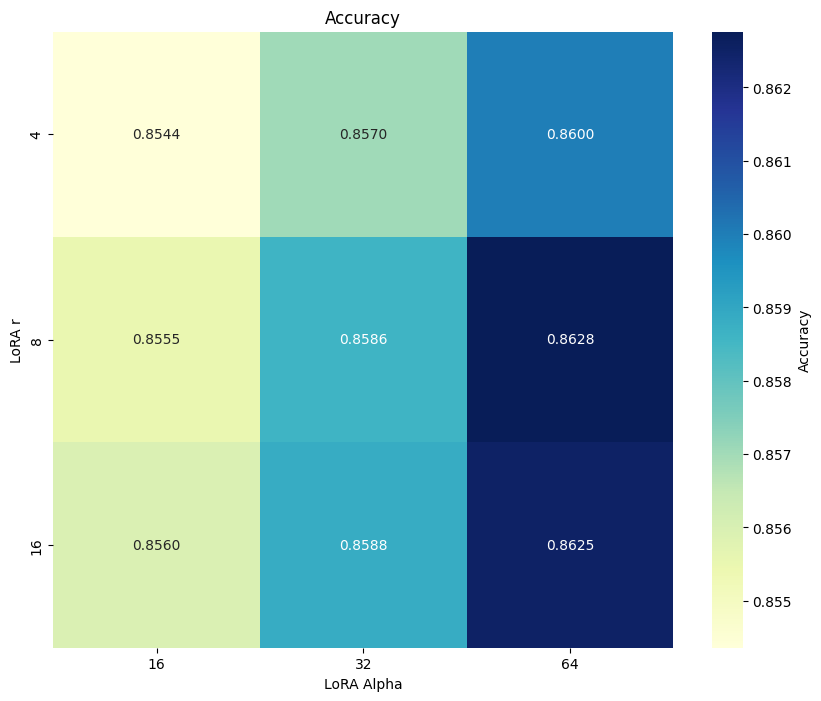

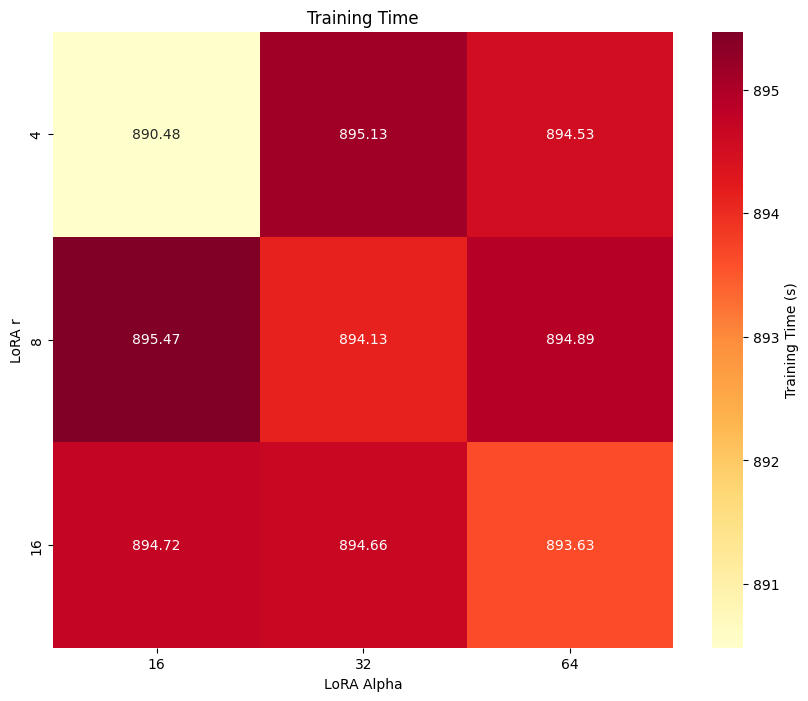

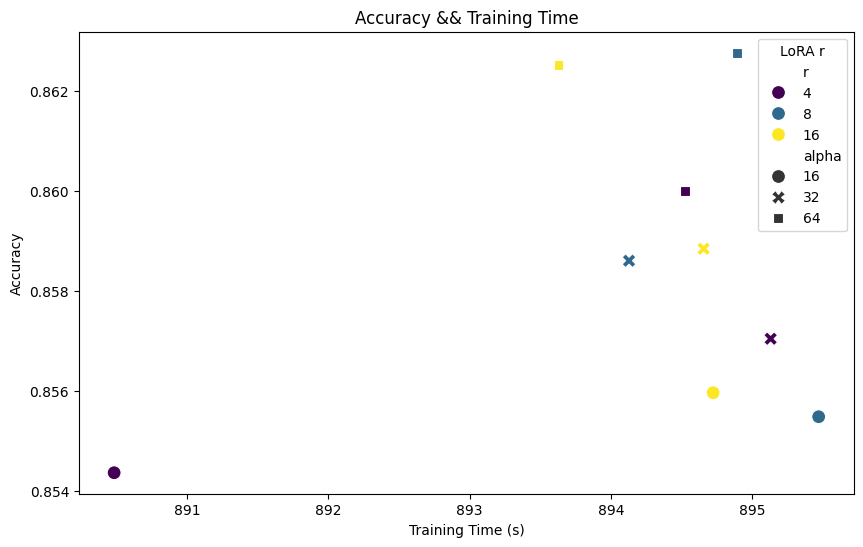

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
results_df = pd.DataFrame(
    results, columns=["r", "alpha", "metrics", "time_taken"])
results_df["accuracy"] = results_df["metrics"].apply(
    lambda x: x["eval_accuracy"])
results_df["loss"] = results_df["metrics"].apply(lambda x: x["eval_loss"])

plt.figure(figsize=(10, 8))
accuracy_pivot = results_df.pivot(
    index="r", columns="alpha", values="accuracy")
sns.heatmap(accuracy_pivot, annot=True, fmt=".4f",
            cmap="YlGnBu", cbar_kws={"label": "Accuracy"})
plt.title("Accuracy")
plt.xlabel("LoRA Alpha")
plt.ylabel("LoRA r")
plt.savefig("accuracy.png")
plt.show()

plt.figure(figsize=(10, 8))
time_pivot = results_df.pivot(index="r", columns="alpha", values="time_taken")
sns.heatmap(time_pivot, annot=True, fmt=".2f", cmap="YlOrRd",
            cbar_kws={"label": "Training Time (s)"})
plt.title("Training Time")
plt.xlabel("LoRA Alpha")
plt.ylabel("LoRA r")
plt.savefig("time.png")
plt.show()

plt.figure(figsize=(10, 6))
sns.scatterplot(
    x="time_taken",
    y="accuracy",
    hue="r",
    style="alpha",
    data=results_df,
    palette="viridis",
    s=100
)
plt.title("Accuracy && Training Time")
plt.xlabel("Training Time (s)")
plt.ylabel("Accuracy")
plt.legend(title="LoRA r")
plt.savefig("accuracy_and_time.png")
plt.show()